## **Russia-Ukraine War: Sentiment Analysis of Tweets**

### 1. Import modules and libraries 

In [86]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pprint import pprint
from itertools import chain
from collections import Counter
import plotly.express as px
import sklearn
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from sklearn.decomposition import NMF
from sklearn.metrics import f1_score, accuracy_score
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import unicodedata
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 
sns.set(style='whitegrid', palette='Dark2')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2. Load Datasets

In [88]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Read data
df1 = pd.read_csv('/content/drive/MyDrive/data2/tweet_data_feb.csv', index_col=0, lineterminator='\n', low_memory= False)
df2 = pd.read_csv('/content/drive/MyDrive/data2/tweet_data_mar.csv', index_col=0, lineterminator='\n', low_memory= False)
df3 = pd.read_csv('/content/drive/MyDrive/data2/tweet_data_apr.csv', index_col=0, lineterminator='\n', low_memory= False)
df4 = pd.read_csv('/content/drive/MyDrive/data2/tweet_data_jul.csv', index_col=0, lineterminator='\n', low_memory= False)
df5 = pd.read_csv('/content/drive/MyDrive/data2/tweet_data_aug.csv', index_col=0, lineterminator='\n', low_memory= False)

In [90]:
# Concat data
df_merged = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df_merged

,userid,tweetcreatedts,text,hashtags
0,962369743,2022-02-24 06:48:02.000000,Footage of the airport bombing in Ivano-Franki...,"[{'text': 'Ukraine', 'indices': [68, 76]}, {'t..."
1,1073676020,2022-02-24 06:48:02.000000,Ukraine MP Sophia Fedyna tells about the groun...,"[{'text': 'ITVideo', 'indices': [130, 138]}]"
2,1040140500718837760,2022-02-24 06:48:03.000000,A cruise missile fired by the Russian army fel...,"[{'text': 'Ukraine', 'indices': [72, 80]}, {'t..."
3,3821643918,2022-02-24 06:48:03.000000,"SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukrain...","[{'text': 'Ukraine', 'indices': [55, 63]}, {'t..."
4,1075087352983216128,2022-02-24 06:48:03.000000,Footage of the airport bombing in Ivano-Franki...,"[{'text': 'Ukraine', 'indices': [68, 76]}, {'t..."
...,...,...,...,...
268260,1498275632471580673,2022-08-25 23:59:35,"@BeKindReWine @AnonOpsSE Oh yea, forgot to men...","[{'text': 'RussiaIsATerroristState', 'indices'..."
268261,1514851881478238213,2022-08-25 23:59:39,A little dose of reality. #Biden's Executive O...,"[{'text': 'Biden', 'indices': [26, 32]}]"
268262,21729540,2022-08-25 23:59:43,Authorities of Zaporizhzhia discuss evacuation...,"[{'text': 'UkraineRussiaWar', 'indices': [139,..."
268263,1434594980148961280,2022-08-25 23:59:48,this mf’s are legitimaly wiping their own debt...,"[{'text': 'PPPLoanForgiveness', 'indices': [10..."


In [91]:
# Select the column needed for analysis
df_tweets = df_merged["text"]
df_tweets.head()

0    Footage of the airport bombing in Ivano-Franki...
1    Ukraine MP Sophia Fedyna tells about the groun...
2    A cruise missile fired by the Russian army fel...
3    SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukrain...
4    Footage of the airport bombing in Ivano-Franki...
Name: text, dtype: object

### 3. Data Cleaning

In [92]:
# Define cleaning functions
def parser(text):
    """removes html tags 
    and attributes using
    BeautifulSoup function
    """
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def normalize(text):
    """normalizes unicode 
    character to regular text
    """
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text

def remove_URL(text):
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'www\S+', '', text)
    return(text)

def remove_mentions(text):
    text = re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+_[A-Za-z0-9]+','',text) 
    text = re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text)
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    return text

def remove_spaces(text):
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'-','',text)
    return text

def remove_nonletter(text):
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    return text

In [93]:
# Clean data with defined functions
df_tweets_cleaned = df_tweets.astype(str).str.lower()
df_tweets_cleaned = df_tweets_cleaned.apply(parser)
df_tweets_cleaned = df_tweets_cleaned.apply(normalize)
df_tweets_cleaned = df_tweets_cleaned.apply(remove_URL)
df_tweets_cleaned = df_tweets_cleaned.apply(remove_mentions)
df_tweets_cleaned = df_tweets_cleaned.apply(remove_spaces)
df_tweets_cleaned = df_tweets_cleaned.apply(remove_nonletter)

In [94]:
# Define stop words
stop_words = set(stopwords.words('english'))
stop_words.add("i'm")
stop_words.add("they're")
stop_words.add("thats")
stop_words.add("tho")
stop_words.add("also")

# Remove stop words
df_tweets_cleaned = df_tweets_cleaned.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_tweets_cleaned.head()

0    footage airport bombing ivanofrankivsk ukraine...
1    ukraine mp sophia fedyna tells ground situatio...
2    cruise missile fired russian army fell kiev uk...
3             spread share help ukraine ukraine russia
4    footage airport bombing ivanofrankivsk ukraine...
Name: text, dtype: object

In [95]:
# Perform lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    words_in_each_tweet = word_tokenize(text)
    final = [lemmatizer.lemmatize(word) for word in words_in_each_tweet]
    lemmatized_tweets = ' '.join(final)
    return lemmatized_tweets

df_tweets_cleaned= df_tweets_cleaned.apply(lemmatizing)
df_tweets_cleaned.head()

0    footage airport bombing ivanofrankivsk ukraine...
1    ukraine mp sophia fedyna tell ground situation...
2    cruise missile fired russian army fell kiev uk...
3             spread share help ukraine ukraine russia
4    footage airport bombing ivanofrankivsk ukraine...
Name: text, dtype: object

### 4. Tweet sentiment classification with VADER model 

In [96]:
# Define VADER function
def VADER(df):
  sid = SentimentIntensityAnalyzer()
  res = df.apply(sid.polarity_scores)
  df_sentiment = pd.DataFrame.from_records(res)
  df_sentiment = pd.concat([df, df_sentiment["compound"]], axis=1)
  conditions = [(df_sentiment['compound'] < 0), (df_sentiment['compound'] >= 0)]
  values = ["neg", "pos"]
  df_sentiment['class'] = np.select(conditions, values)
  return df_sentiment

df_tweets_class = VADER(df_tweets_cleaned)
df_tweets_class.head()

,text,compound,class
0,footage airport bombing ivanofrankivsk ukraine...,0.0000,pos
1,ukraine mp sophia fedyna tell ground situation...,0.1280,pos
2,cruise missile fired russian army fell kiev uk...,-0.5574,neg
3,spread share help ukraine ukraine russia,0.5994,pos
4,footage airport bombing ivanofrankivsk ukraine...,0.0000,pos


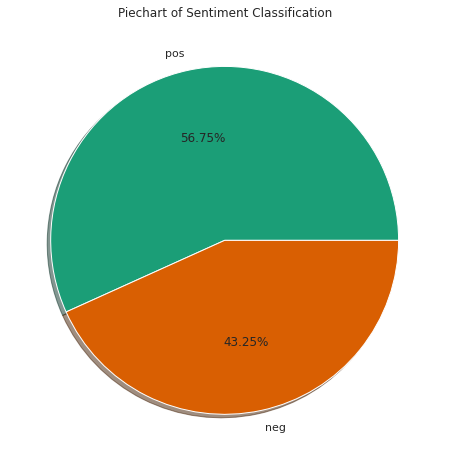

In [97]:
# Fig 1
# Visualize the result of VADER sentiment classification
def piechart_plotter(df):
  df_pie = df.copy()
  df_pie["Count"] = df_pie['class'].map(df_pie['class'].value_counts()) 
  df_pie.drop(['text', 'compound'], axis=1, inplace=True)
  df_pie.drop_duplicates(inplace=True)
  plt.pie(df_pie.Count, labels=df_pie['class'], autopct="%1.2f%%", shadow=True)
  plt.title('Piechart of Sentiment Classification')
  plt.show()

piechart_plotter(df_tweets_class) 

### 5. Keyword extraction using NMF

In [98]:
# Filter dataset
df_tweets_pos = df_tweets_class[df_tweets_class['class'] == 'pos'].drop_duplicates().reset_index(drop=True)
df_tweets_neg = df_tweets_class[df_tweets_class['class'] == 'neg'].drop_duplicates().reset_index(drop=True)

# Define TFIDF vectorizer and fit
tfidf_pos = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
tfidf_neg = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
tfidf_feature_pos = tfidf_pos.fit_transform(df_tweets_pos['text'].values.astype('U'))
tfidf_feature_neg = tfidf_neg.fit_transform(df_tweets_neg['text'].values.astype('U'))

# Define NMF model and fit
nmf_pos = NMF(n_components=5, max_iter=500, random_state=1)
nmf_pos.fit(tfidf_feature_pos)

nmf_neg = NMF(n_components=5, max_iter=500, random_state=1)
nmf_neg.fit(tfidf_feature_neg)

# Extract keywords
for i,topic in enumerate(nmf_pos.components_): 
    print(f'Top 10 keywords from positive tweets #{i}:')
    print([tfidf_pos.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

for i,topic in enumerate(nmf_neg.components_): 
    print(f'Top 10 keywords from negative tweets #{i}:')
    print([tfidf_neg.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 keywords from positive tweets #0:
['news', 'help', 'country', 'peace', 'invasion', 'support', 'people', 'nato', 'russia', 'ukraine']


Top 10 keywords from positive tweets #1:
['fourthofjuly', 'america', 'thofjuly', 'day', 'independence', 'independenceday', 'th', 'july', 'usa', 'happy']


Top 10 keywords from positive tweets #2:
['ukraina', 'ukrainerussiacrisis', 'russiaukraine', 'russia', 'nato', 'biden', 'wwiii', 'russiaukraineconflict', 'worldwar', 'putin']


Top 10 keywords from positive tweets #3:
['support', 'friend', 'people', 'thank', 'nft', 'follow', 'like', 'giveaway', 'slavaukraini', 'standwithukraine']


Top 10 keywords from positive tweets #4:
['region', 'soldier', 'army', 'kyiv', 'ukrainewar', 'military', 'ukrainerussiawar', 'force', 'ukrainian', 'russian']


Top 10 keywords from negative tweets #0:
['sanction', 'military', 'china', 'country', 'invasion', 'news', 'attack', 'nato', 'ukraine', 'russia']


Top 10 keywords from negative tweets #1:
['attack', 'civilian'

### 6. Ngram Extraction and Visualization

In [99]:
# Select pos and neg tweets for analysis
df_tweets_text_pos = df_tweets_pos['text']
df_tweets_text_neg = df_tweets_neg['text']

In [100]:
# Define CountVectorizer features
def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [101]:
# Define function to plot n-grams
def plt_ngram(words, range, title):
    n_grams = get_top_n_gram(words, range, 20)
    plt.figure(figsize=(8, 5), dpi=600) 
    sns_plot = sns.barplot(x=1, y=0, data=pd.DataFrame(n_grams))
    plt.ylabel("Phrases")
    plt.xlabel("Count")
    plt.title(title)

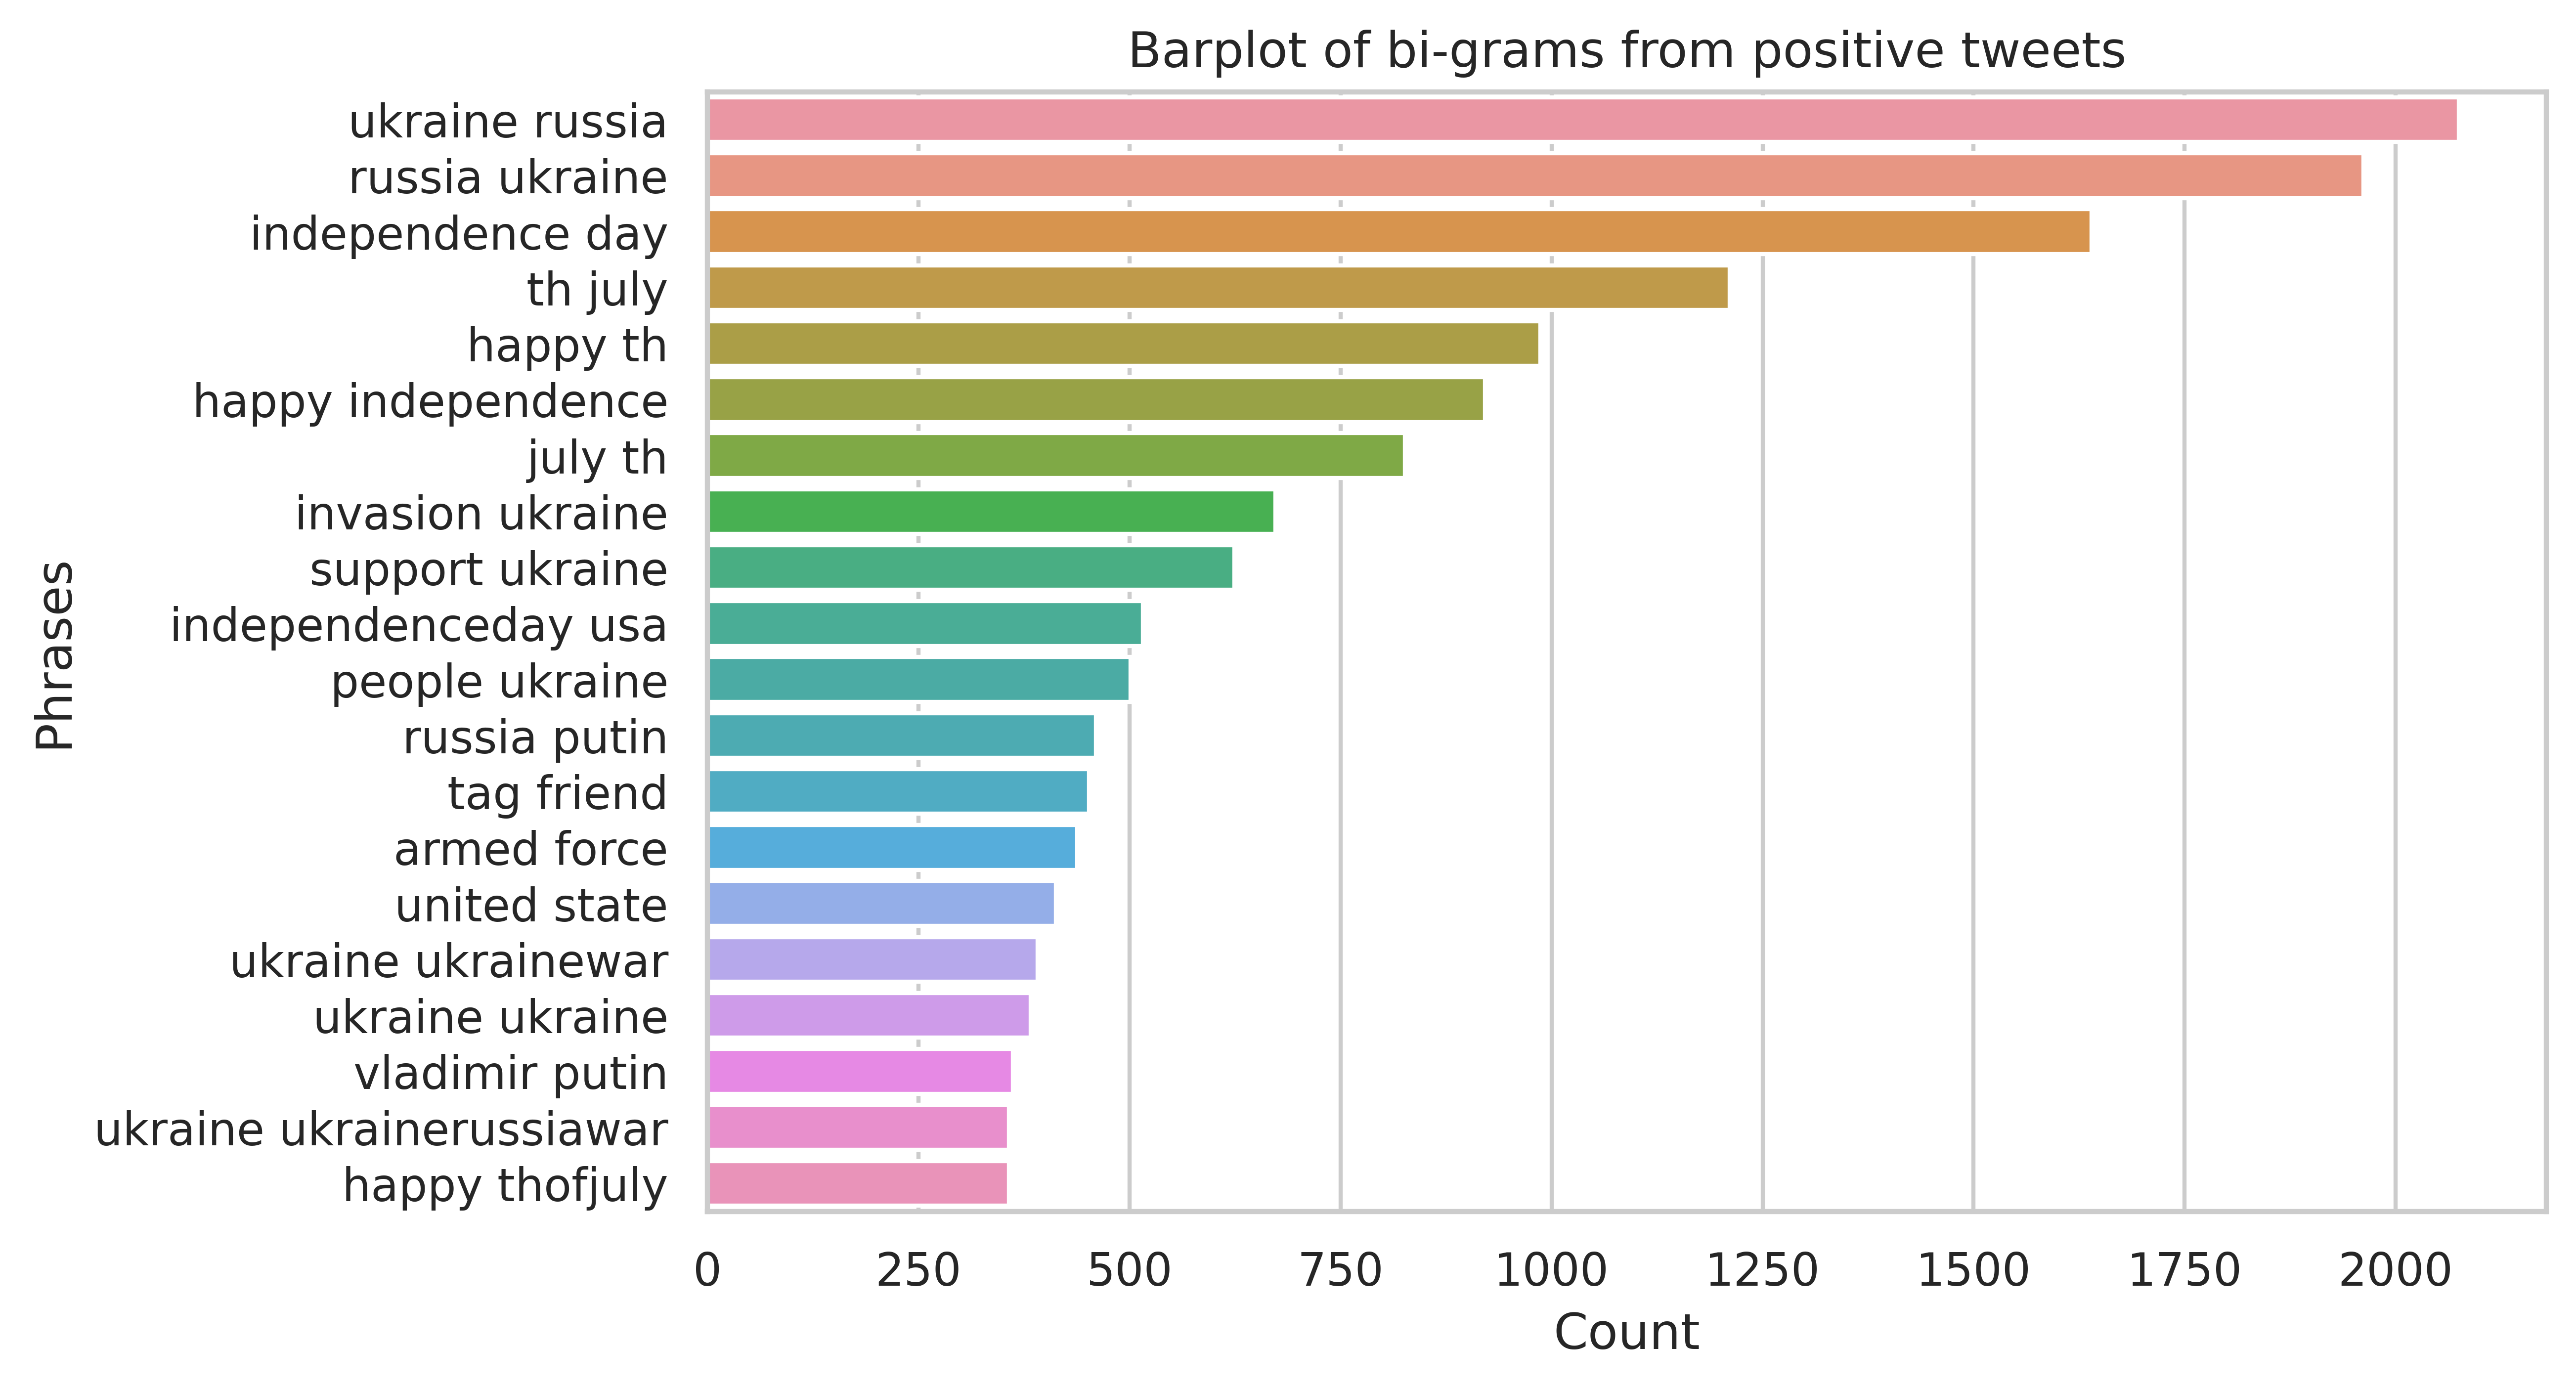

In [102]:
# Fig 2
# Plot bi_gram from positive tweets
plt_ngram(df_tweets_text_pos, (2, 2), 'Barplot of bi-grams from positive tweets')

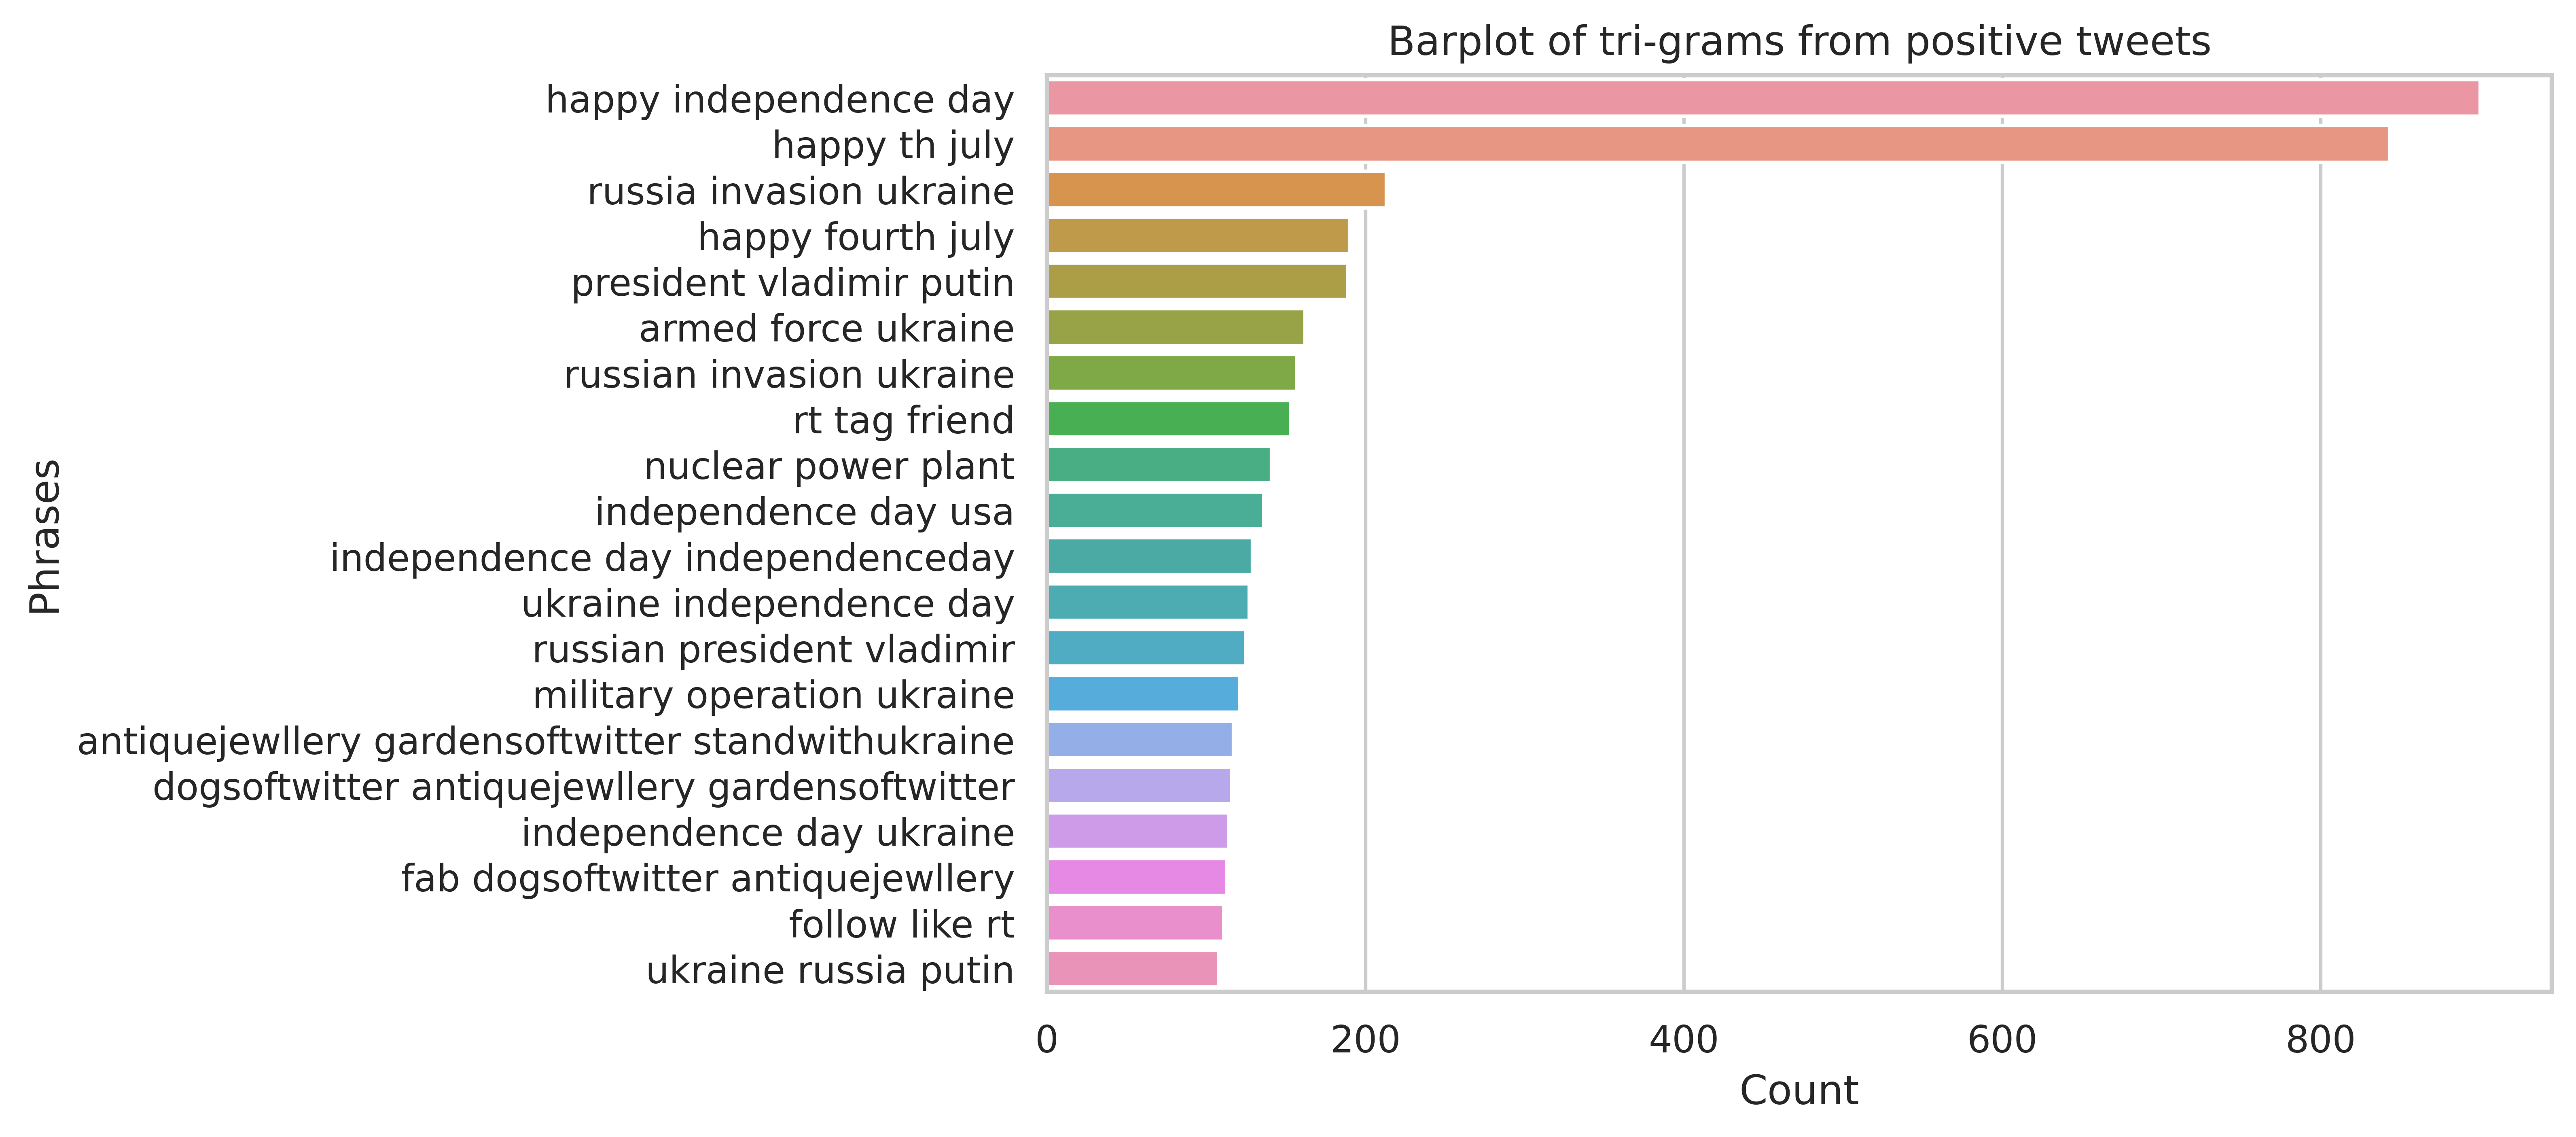

In [103]:
# Fig 3
# Plot tri_gram from positive tweets
plt_ngram(df_tweets_text_pos, (3, 3), 'Barplot of tri-grams from positive tweets')

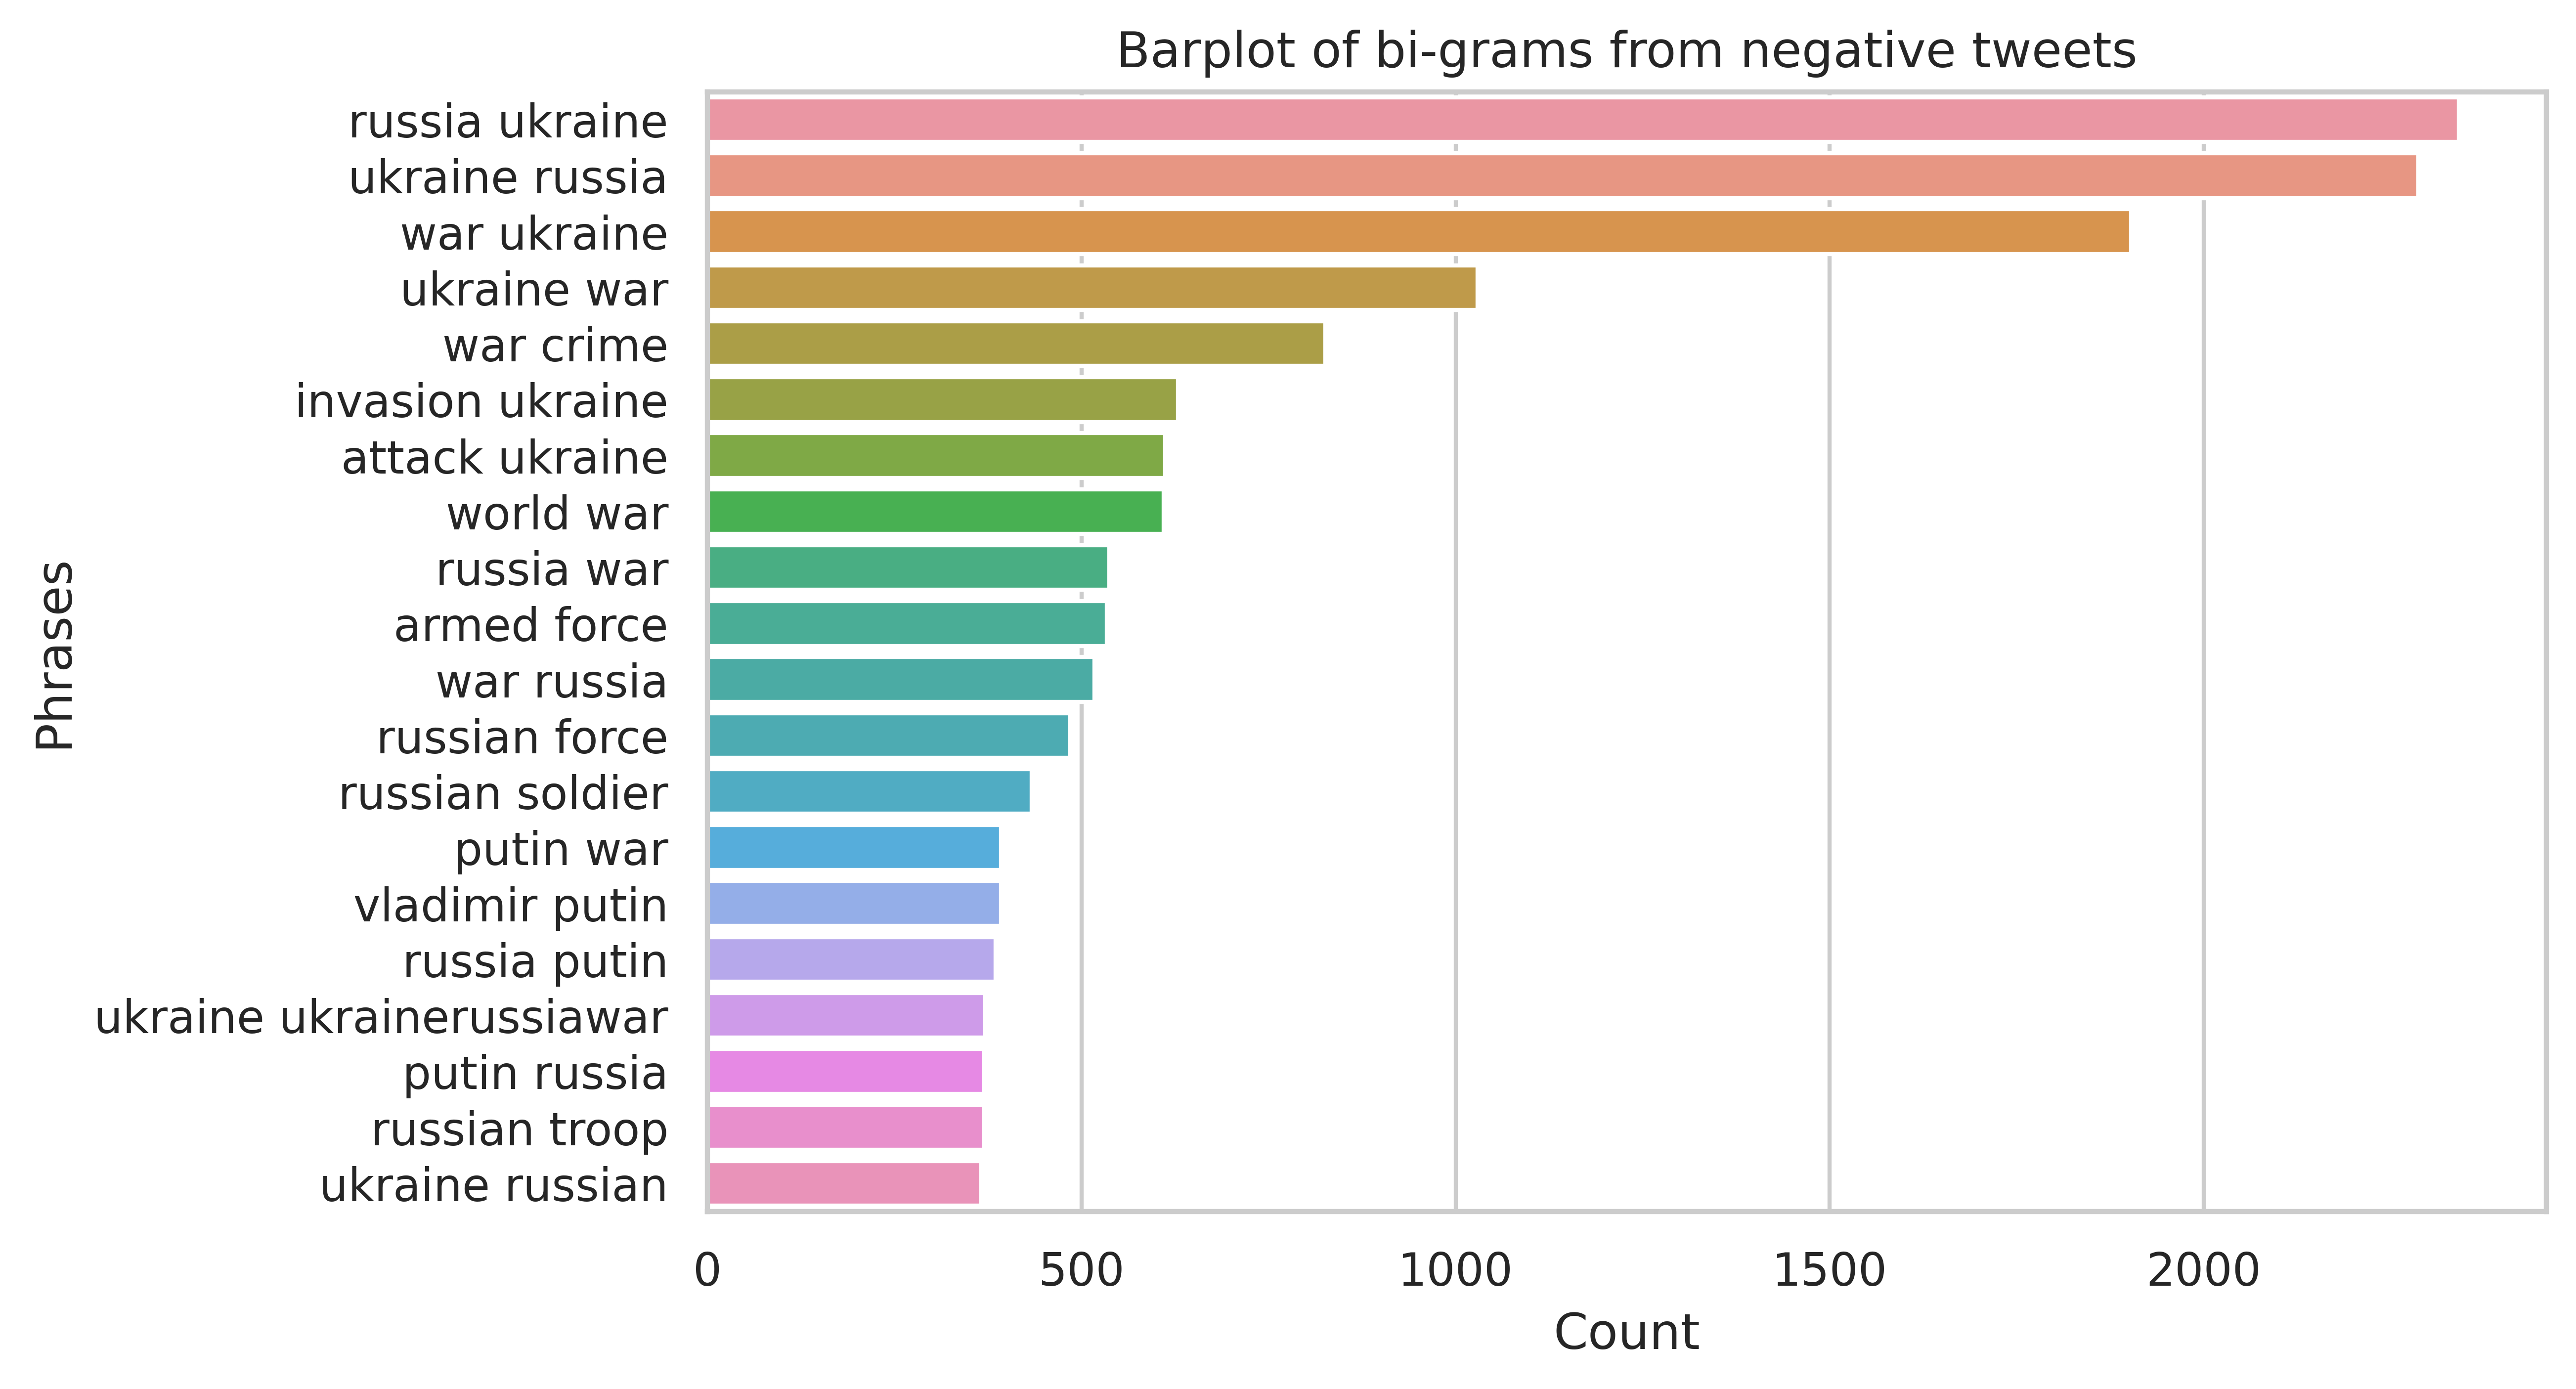

In [104]:
# Fig 4
# Plot bi_gram from negative tweets
plt_ngram(df_tweets_text_neg, (2, 2), 'Barplot of bi-grams from negative tweets')

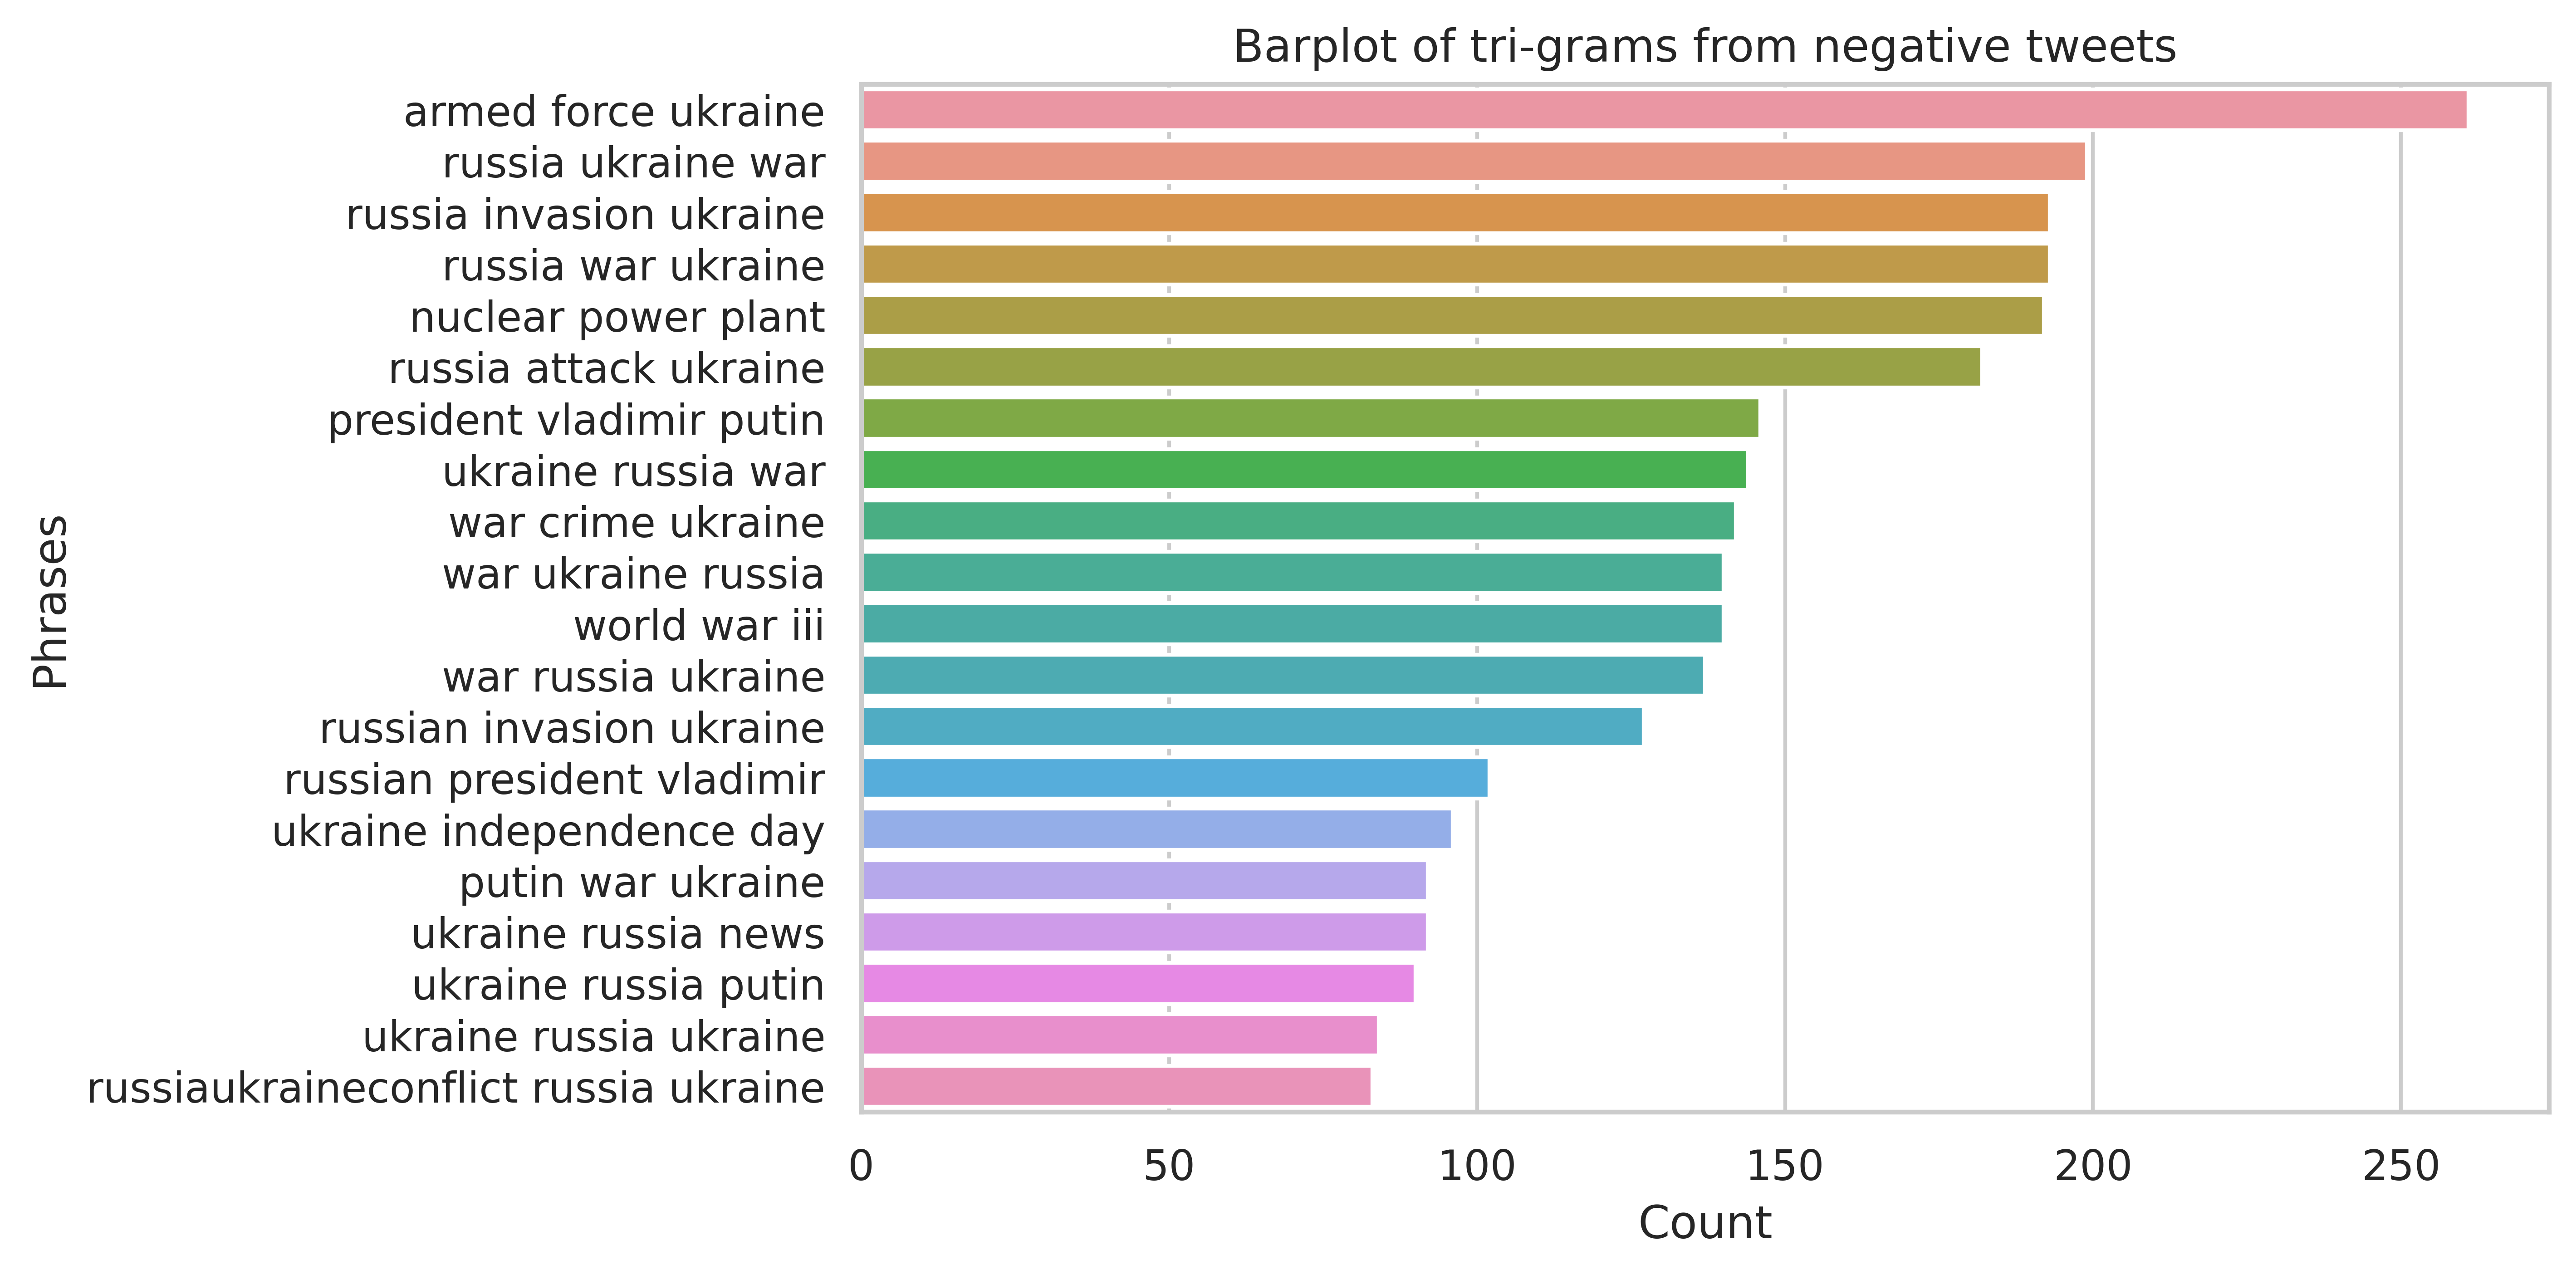

In [105]:
# Fig 5
# Plot tri_gram from negative tweets
plt_ngram(df_tweets_text_neg, (3, 3), 'Barplot of tri-grams from negative tweets')

### 7. WordCloud Visualizations

In [106]:
# Buid function to prepare data
def prepare_data_wordcloud(df):
  
  # Generate features using tfidf
  tfidf_vectorizer = TfidfVectorizer(max_features=50, binary=True, norm=None, use_idf=False)
  tfidf_vec = tfidf_vectorizer.fit_transform(df.values.astype('U'))
  tfidf_array = tfidf_vec.toarray()
  TFIDF_features = pd.DataFrame(data=tfidf_array, columns = tfidf_vectorizer.get_feature_names_out())

  # Generate word frequency in df
  word_vec = TFIDF_features.columns.values.reshape(-1,1)
  word_count = TFIDF_features.sum().values.reshape(-1,1)
  word_count_array = np.hstack((word_vec, word_count))
  df_word_count = pd.DataFrame(data=word_count_array, columns=["word", "count"])
  return df_word_count

In [107]:
# Build function to display wordcloud
def display_wordcloud(df, title):
  tuples = [tuple(x) for x in df.values]
  wordcloud = WordCloud(background_color = 'white', width=500, height=300).generate_from_frequencies(dict(tuples))
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(title)
  plt.show()

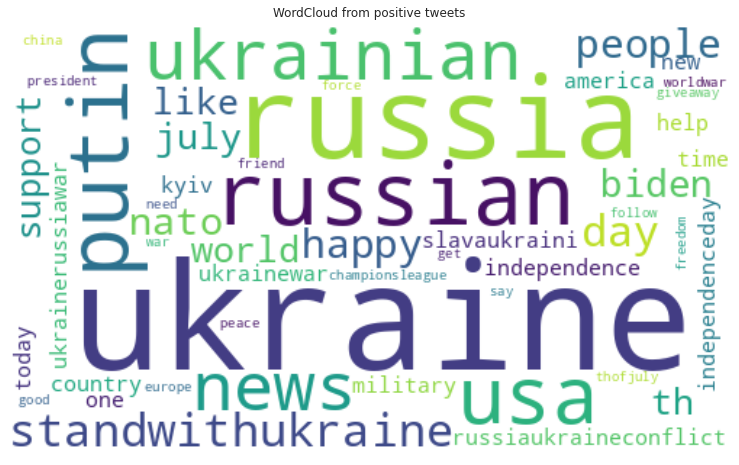

In [108]:
# Fig 6
# Display wordcloud from positive tweets
df_word_count_pos = prepare_data_wordcloud(df_tweets_text_pos)
word_cloud_pos = display_wordcloud(df_word_count_pos, "WordCloud from positive tweets")

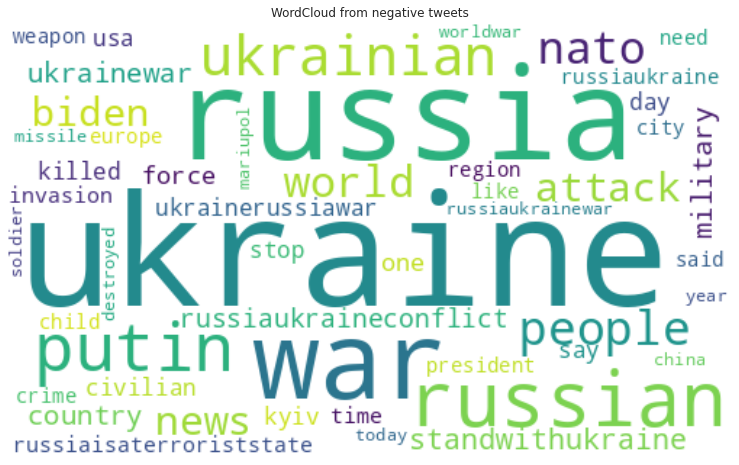

In [109]:
# Fig 7
# Display wordcloud from negative tweets
df_word_count_neg = prepare_data_wordcloud(df_tweets_text_neg)
word_cloud_neg = display_wordcloud(df_word_count_neg, "WordCloud from negative tweets")

### 8. Analyzing hashtags

In [110]:
# Clean data with defined functions, retain hashtags and special characters
df_hashtag_clean = df_tweets.astype(str).str.lower()
df_hashtag_clean = df_hashtag_clean.apply(parser)
df_hashtag_clean = df_hashtag_clean.apply(normalize)
df_hashtag_clean = df_hashtag_clean.apply(remove_URL)
df_hashtag_clean = df_hashtag_clean.apply(remove_mentions)
df_hashtag_clean = df_hashtag_clean.apply(remove_spaces)

In [111]:
# Remove stop words
df_hashtag_clean = df_hashtag_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_hashtag_clean.head()

0    footage airport bombing ivanofrankivsk. #ukrai...
1    ukraine mp sophia fedyna tells ground situatio...
2    cruise missile fired russian army fell kiev #u...
3          spread share, help ukraine #ukraine #russia
4    footage airport bombing ivanofrankivsk. #ukrai...
Name: text, dtype: object

In [112]:
# Concat clean text containing hashtags with label
df_hashtag_label = pd.concat([pd.DataFrame(df_hashtag_clean), pd.DataFrame(df_tweets_class['class'])], axis = 1)
df_hashtag_label.head()

,text,class
0,footage airport bombing ivanofrankivsk. #ukrai...,pos
1,ukraine mp sophia fedyna tells ground situatio...,pos
2,cruise missile fired russian army fell kiev #u...,neg
3,"spread share, help ukraine #ukraine #russia",pos
4,footage airport bombing ivanofrankivsk. #ukrai...,pos


In [113]:
# Filter dataset
df_hashtag_pos = df_hashtag_label[df_hashtag_label['class'] == 'pos'].drop_duplicates().reset_index(drop=True)
df_hashtag_pos = df_hashtag_pos["text"]
df_hashtag_neg = df_hashtag_label[df_hashtag_label['class'] == 'neg'].drop_duplicates().reset_index(drop=True)
df_hashtag_neg = df_hashtag_neg["text"]

In [114]:
# Define function to extract hashtag into a list
def extract_hashtags(df):
    hashtag = []
    for i in df.index:
      hash = re.findall(r"#(\w+)", df[i])
      hashtag.extend(hash)
    return hashtag

In [115]:
# Extract hashtags in (+ve & -ve) tweets into a list
hashtags_pos_list = extract_hashtags(df=df_hashtag_pos)
hashtags_neg_list = extract_hashtags(df=df_hashtag_neg)

In [116]:
# Read the count of most common hashtags for (-ve & +ve) tweets
hashtag_count_pos = Counter(hashtags_pos_list)
hashtag_count_neg = Counter(hashtags_neg_list)
hashtag_count_pos_df = pd.DataFrame.from_records(hashtag_count_pos.most_common(50), columns=['hashtags','count'])
hashtag_count_neg_df = pd.DataFrame.from_records(hashtag_count_neg.most_common(50), columns=['hashtags','count'])

In [117]:
hashtag_count_pos_df.head()

,hashtags,count
0,ukraine,22493
1,russia,11383
2,usa,5675
3,putin,4732
4,standwithukraine,4149


In [118]:
hashtag_count_neg_df.head()

,hashtags,count
0,ukraine,21070
1,russia,12448
2,putin,5033
3,russian,3217
4,nato,2443


### 9. Hashtag Visualizations

In [119]:
# Fig 8
# Create barplot for frequency of hashtags from positive tweets
fig = px.bar(hashtag_count_pos_df, x="count", y="hashtags", title='Commmon hashtags in positive tweets', orientation='h', 
             width=700, height=1000,color='hashtags')
fig.show()

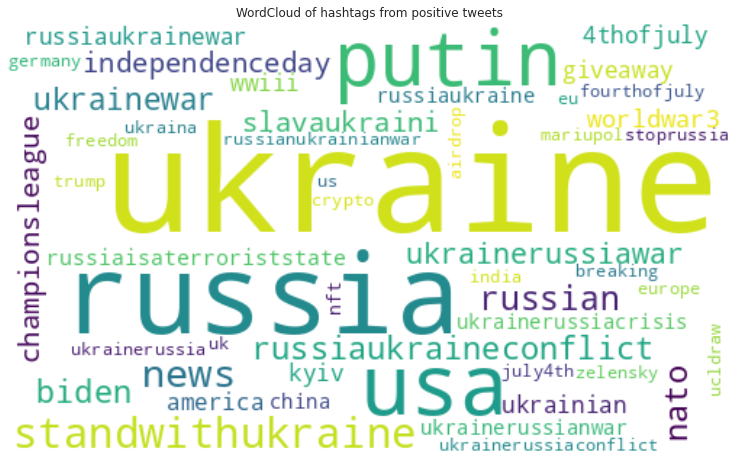

In [120]:
# Fig 9
# Create wordcloud for the hashtags in positive tweets
display_wordcloud(hashtag_count_pos_df, "WordCloud of hashtags from positive tweets")

In [121]:
# Fig 10
# Create barplot for frequency of hashtags from negative tweets
fig = px.bar(hashtag_count_neg_df, x="count", y="hashtags", title='Commmon hashtags in negative tweets', orientation='h', 
             width=700, height=1000,color='hashtags')
fig.show()

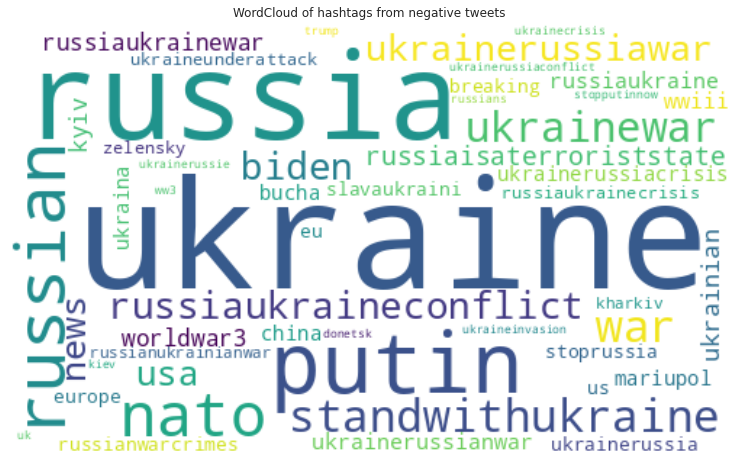

In [122]:
# Fig 11
# Create wordcloud for the hashtags in negative tweets
display_wordcloud(hashtag_count_neg_df, "WordCloud of hashtags from negative tweets")

### 10. Time series of tweets 


In [123]:
# Prepare df for time series analysis
df_time_series = pd.concat([df_tweets_class, pd.DataFrame(df_merged.tweetcreatedts)], axis=1)
df_time_series.head()

,text,compound,class,tweetcreatedts
0,footage airport bombing ivanofrankivsk ukraine...,0.0000,pos,2022-02-24 06:48:02.000000
1,ukraine mp sophia fedyna tell ground situation...,0.1280,pos,2022-02-24 06:48:02.000000
2,cruise missile fired russian army fell kiev uk...,-0.5574,neg,2022-02-24 06:48:03.000000
3,spread share help ukraine ukraine russia,0.5994,pos,2022-02-24 06:48:03.000000
4,footage airport bombing ivanofrankivsk ukraine...,0.0000,pos,2022-02-24 06:48:03.000000


In [124]:
# Filter df by month
df_feb = df_time_series[df_time_series['tweetcreatedts'].str.contains("2022-02-24")]
df_mar = df_time_series[df_time_series['tweetcreatedts'].str.contains("2022-03-24")]
df_apr = df_time_series[df_time_series['tweetcreatedts'].str.contains("2022-04-07")]
df_jul = df_time_series[df_time_series['tweetcreatedts'].str.contains("2022-07-04")]
df_aug = df_time_series[df_time_series['tweetcreatedts'].str.contains("2022-08-25")]

In [125]:
# Filter df by (+ or -)
df_feb_pos = df_feb[df_feb['class'] == 'pos']
df_feb_neg = df_feb[df_feb['class'] == 'neg']

df_mar_pos = df_mar[df_mar['class'] == 'pos']
df_mar_neg = df_mar[df_mar['class'] == 'neg']

df_apr_pos = df_apr[df_apr['class'] == 'pos']
df_apr_neg = df_apr[df_apr['class'] == 'neg']

df_jul_pos = df_jul[df_jul['class'] == 'pos']
df_jul_neg = df_jul[df_jul['class'] == 'neg']

df_aug_pos = df_aug[df_aug['class'] == 'pos']
df_aug_neg = df_aug[df_aug['class'] == 'neg']

In [126]:
# Count number of tweets by month
pos_counts = [df_feb_pos.shape[0],df_mar_pos.shape[0],df_apr_pos.shape[0], df_jul_pos.shape[0],df_aug_pos.shape[0]]
neg_counts = [df_feb_neg.shape[0],df_mar_neg.shape[0],df_apr_neg.shape[0], df_jul_neg.shape[0],df_aug_neg.shape[0]]
pos_counts_array = np.array(pos_counts)
neg_counts_array = np.array(neg_counts)
total_count = pos_counts_array + pos_counts_array
dates = ["2022-02-24","2022-03-24", "2022-04-07","2022-07-04", "2022-08-25"]

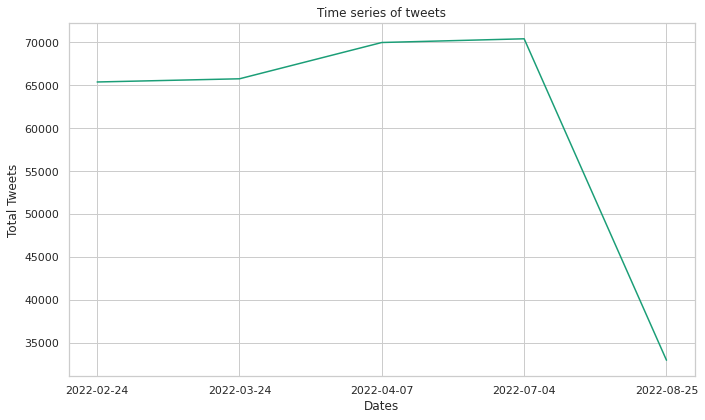

In [127]:
# Fig 12
# Plot time series for total tweets
plt.figure(figsize=(10,6), tight_layout=True)
plt.plot(dates, total_count)
plt.title('Time series of tweets')
plt.xlabel("Dates")
plt.ylabel("Total Tweets")
plt.show()

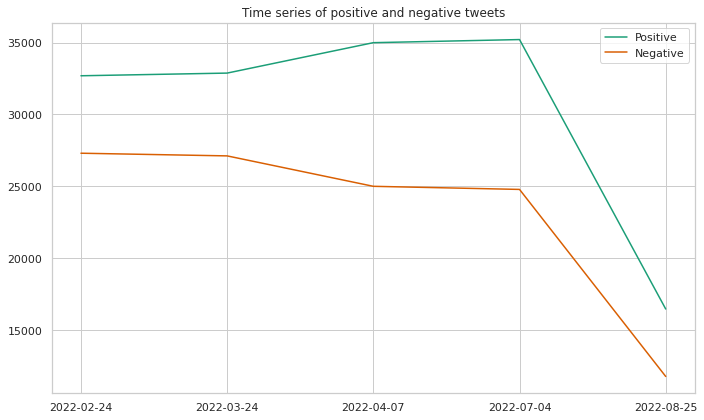

In [128]:
# Fig 13
# Plot time series for (+ & -) tweets
plt.figure(figsize=(10,6), tight_layout=True)
plt.plot(dates, pos_counts)
plt.plot(dates, neg_counts)
plt.title('Time series of positive and negative tweets')
plt.legend(labels=['Positive', 'Negative'])
plt.show()